# SRS Files only

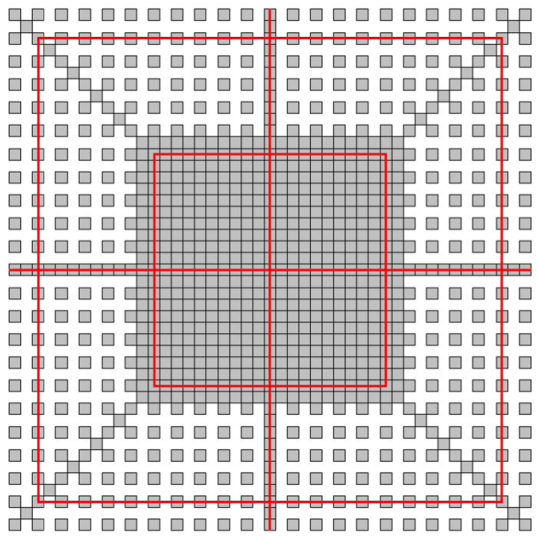

# Libraries

In [1]:
# LIBRARIES #

import numpy as np

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import LinearColorMapper, BasicTicker, ColorBar, Plot, CustomJS, ColumnDataSource, Rect, HoverTool
from bokeh.layouts import row, gridplot, column
from bokeh.models.widgets import Slider

output_notebook()

Loading BokehJS ...

# Classes mc2 & SRS

In [2]:
class mc2:

    """Defines an mc2 class with the required attributes"""

    def __init__(self, 
                 measdate = "", linac = "", modality = "", inplane_axis ="", crossplane_axis="", 
                 depth_axis = "", inplane_axis_dir = "", crossplane_axis_dir = "", depth_axis_dir = "", 
                 energy = "", ssd = "", field_inplane = "", field_crossplane = "", scan_curvetype = "", 
                 scan_depth = "", scan_offaxis_inplane = "", scan_offaxis_crossplane = "", meas_time = "", 
                 meas_unit = "", xdata = "", ydata = "", refdata = "", scan_diagonal = ""):
        """ Constructs the object mc2 """
        self.measdate = measdate
        self.linac = linac
        self.modality = modality
        self.inplane_axis = inplane_axis
        self.crossplane_axis = crossplane_axis
        self.depth_axis = depth_axis
        self.inplane_axis_dir = inplane_axis_dir
        self.crossplane_axis_dir = crossplane_axis_dir
        self.depth_axis_dir = depth_axis_dir
        self.energy = energy
        self.ssd = ssd
        self.field_inplane = field_inplane
        self.field_crossplane = field_crossplane
        self.scan_curvetype = scan_curvetype
        self.scan_depth = scan_depth
        self.scan_offaxis_inplane = scan_offaxis_inplane
        self.scan_offaxis_crossplane = scan_offaxis_crossplane
        self.meas_time = meas_time
        self.meas_unit = meas_unit
        self.xdata = xdata
        self.ydata = ydata
        self.refdata = refdata
        self.scan_diagonal = scan_diagonal

        
    def setVariables(self, measdate, linac, modality, inplane_axis, crossplane_axis, 
                 depth_axis, inplane_axis_dir, crossplane_axis_dir, depth_axis_dir, 
                 energy, ssd, field_inplane, field_crossplane, scan_curvetype, 
                 scan_depth, scan_offaxis_inplane, scan_offaxis_crossplane, meas_time, 
                 meas_unit, xdata, ydata, refdata, scan_diagonal):
        """ Fills the variables """
        self.measdate = measdate
        self.linac = linac
        self.modality = modality
        self.inplane_axis = inplane_axis
        self.crossplane_axis = crossplane_axis
        self.depth_axis = depth_axis
        self.inplane_axis_dir = inplane_axis_dir
        self.crossplane_axis_dir = crossplane_axis_dir
        self.depth_axis_dir = depth_axis_dir
        self.energy = energy
        self.ssd = ssd
        self.field_inplane = field_inplane
        self.field_crossplane = field_crossplane
        self.scan_curvetype = scan_curvetype
        self.scan_depth = scan_depth
        self.scan_offaxis_inplane = scan_offaxis_inplane
        self.scan_offaxis_crossplane = scan_offaxis_crossplane
        self.meas_time = meas_time
        self.meas_unit = meas_unit
        self.xdata = xdata
        self.ydata = ydata
        self.refdata = refdata
        self.scan_diagonal = scan_diagonal
        
        
    def datasetinfo(file):
        """Finds datasets within a file and returns some useful info so you can decide
        which one you need
        Returns the start and end lines, acquisition date, energy,field size, direction and depth
        Call as 'DataStart, DataEnd, MeasDate, Energy, FieldSize, Depth=datasetinfo(inputfile)' """

        datasets = 0
        ifile = open(file, 'r') 
        lines = ifile.readlines()
        datasets = 0
        lineNumber = 0
        BeginScan=[]; EndScan=[]; MeasDate = []; Energy = []; FieldSize=[]; Depth=[]; Direction=[]
        for line in lines:
            line = line.replace('\t', ',')      # replaces all the tabs with commas
            line = line.rstrip('\r\n')            # strips any control characters from the end of the line

            if ("BEGIN_SCAN" in line) and ("DATA" not in line):
                BeginScan.append(lineNumber)
                datasets = datasets+1

            if "MEAS_DATE" in line:
                MeasDate.append(line.split("=")[1])

            if "ENERGY" in line:
                Energy.append(int((line.split("=")[1]).split('.')[0]))
                # This rather convoluted line extracts the integer from a string 
                # e.g the string "6.00" is converted to the integer "6"
                #  Energy=(int(line.split('.')[0]))

            if "SCAN_DEPTH=" in line:
                Depth.append(int((line.split("=")[1]).split('.')[0]))

            if ("FIELD_INPLANE" in line) and ("REF" not in line):
                FieldSize.append((int((line.split("=")[1]).split('.')[0]))/10) # convert from mm to cm
                # This probably shouldn't be relied upon as the direction
                # in the old data appears to be quite unreliable.
                # The filename appears to be a more reliable guide to the scan direction!

            if "SCAN_CURVETYPE=" in line:
                answer = (line.split("=")[1])
                if (line.split("=")[1]) == "CROSSPLANE_PROFILE":
                    Direction.append("AB(X)")
                if (line.split("=")[1]) == "INPLANE_PROFILE":
                    Direction.append("GT(Y)")

            if ("END_SCAN" in line) and ("DATA" not in line):
                EndScan.append(lineNumber)

            lineNumber = lineNumber + 1
                
        return BeginScan, EndScan, MeasDate, Energy, FieldSize, Depth, Direction

        
    def extractdata(self, line):
        """For each line, return the x and y values, check whether there is reference value
        and if so return the reference value, otherwise return a reference	value of 1 """
    
        newArray = (line.split(','))
            
        if len(newArray) == 8:
            # convert the strings to floats
            xvalue = float(newArray[3])
            yvalue =  float(newArray[5])
            if (newArray[7][0]=='#'):
                refvalue = float(newArray[7][1:])
            else:
                refvalue =  float(newArray[7])
            return xvalue, yvalue, refvalue
    
        if len(newArray) == 6:
            # convert the strings to floats
            xvalue = float(newArray[3])
            yvalue =  float(newArray[5])
            refvalue = 1
            return xvalue, yvalue, refvalue
        else:
            print("Houston, we have a problem, This line does not appear to be data!:")
            print(line)
        
        
        
    def read_profile_srs(self, file, datastartline, dataendline):
        """Read data from the mc2 file and fills the instance of the mc2 class
        As files can contain more than one dataset the start and end line numbers
        need to be supplied.
        These can be obtained using datasetinfo(file)
        Use as dataset = read_mc2(file, datastartline, dataendline)"""

        lineNumber = 0
        dataline = 0
        ifile = open(file, 'r') 
        lines = ifile.readlines()
        linac="N/A"  # earlier versions of the mc2 software didn't include this field, if it is missing then N/A will be returned instead

        for line in lines:
            line = line.replace('\t', ',')  # replaces tabs with commas
            line = line.rstrip('\r\n')         # strips control characters from the end of the line

            if (lineNumber > datastartline) and (lineNumber < dataendline):
                if "MEAS_DATE" in line:
                    self.measdate = (line.split("=")[1])

                elif "LINAC" in line:
                    self.linac = (line.split("=")[1])

                elif "MODALITY=" in line:
                    self.modality = (line.split("=")[1])

                elif "INPLANE_AXIS=" in line:
                    self.inplane_axis = (line.split("=")[1])

                elif "CROSSPLANE_AXIS=" in line:
                    self.crossplane_axis = (line.split("=")[1])

                elif "DEPTH_AXIS=" in line:
                    self.depth_axis = (line.split("=")[1])

                elif "INPLANE_AXIS_DIR=" in line:
                    self.inplane_axis_dir = (line.split("=")[1])

                elif "CROSSPLANE_AXIS_DIR=" in line:
                    self.crossplane_axis_dir = (line.split("=")[1])

                elif "DEPTH_AXIS_DIR=" in line:
                    self.depth_axis_dir_tmp = (line.split("=")[1])

                elif "ENERGY" in line:
                    self.energy = (float((line.split("=")[1]).split('.')[0])) # converts from text to an integer

                elif "SSD=" in line:
                    self.ssd = (float((line.split("=")[1]).split('.')[0])) # converts from text to an integer

                elif ("FIELD_INPLANE" in line) and ("REF" not in line):
                    self.field_inplane =(float((line.split("=")[1]).split('.')[0]))# converts from text to an integer

                elif  ("FIELD_CROSSPLANE" in line) and ("REF" not in line):
                    self.field_crossplane = (float((line.split("=")[1]).split('.')[0])) # converts from text to an integer

                elif "SCAN_CURVETYPE" in line:
                    self.scan_curvetype = (line.split("=")[1])

                elif "SCAN_DEPTH=" in line:
                    self.scan_depth  = (float(line.split("=")[1])) # converts from text to an integer

                elif "SCAN_OFFAXIS_INPLANE=" in line:
                    self.scan_offaxis_inplane = (float(line.split("=")[1])) # converts from text to an integer

                elif "SCAN_OFFAXIS_CROSSPLANE=" in line:
                    self.scan_offaxis_crossplane = float(line.split("=")[1]) # converts from text to an integer

                elif "MEAS_TIME=" in line:
                    self.meas_time = (line.split("=")[1])

                elif "MEAS_UNIT=" in line:
                    self.meas_unit = (line.split("=")[1])

                elif "SCAN_DIAGONAL=" in line:
                    self.scan_diagonal = (line.split("=")[1])

                elif line.startswith(',,,'):     # this must be our data
                    if dataline == 0:
                        xvalue, yvalue, refvalue = self.extractdata(line)
                        self.xdata = np.zeros(0)
                        self.xdata = xvalue
                        self.ydata = np.zeros(0)
                        self.ydata = yvalue
                        self.refdata = np.zeros(0)
                        self.refdata = refvalue
                    else:
                        xvalue, yvalue, refvalue = self.extractdata(line)
                        self.xdata = np.hstack([self.xdata, xvalue])
                        self.ydata = np.hstack([self.ydata, yvalue])
                        self.refdata = np.hstack([self.refdata, refvalue])
                    dataline = dataline + 1

            lineNumber = lineNumber + 1
    
    
    
    

In [55]:
class SRSmatrix:

    """Defines an mc2 class with the required attributes"""

    NBPIX_X = 45
    NBPIX_Y = 45
    
    def __init__(self):
        self.img = np.zeros((self.NBPIX_X, self.NBPIX_Y))



    def readSRSmccFile(self, filepath):
        beginScan, endScan, measDate, energy, fieldSize, depth, direction = mc2.datasetinfo(filepath)
        
        for i in range(len(beginScan)):
            a = mc2()
            a.read_profile_srs(filepath, beginScan[i], endScan[i])
            if (a.scan_curvetype == 'CROSSPLANE_PROFILE'):
                ypos = int(a.scan_offaxis_inplane/2.5)
                for j in range(len(a.xdata)):
                    xpos = int(a.xdata[j]/2.5)
                    self.img[ypos+22, xpos+22] = a.ydata[j]
            elif (a.scan_curvetype == 'INPLANE_PROFILE'):
                if (a.scan_diagonal == 'NOT_DIAGONAL'):
                    xpos = int(a.scan_offaxis_crossplane/2.5)
                    for j in range(len(a.xdata)):
                        ypos = int(a.xdata[j]/2.5)
                        self.img[ypos+22, xpos+22] = a.ydata[j]
                elif (a.scan_diagonal == 'FIRST_DIAGONAL'):
                    for j in range(len(a.xdata)):
                        self.img[j, j] = a.ydata[j]
                elif (a.scan_diagonal == 'SECOND_DIAGONAL'):
                    for j in range(len(a.xdata)):
                        self.img[j, 44-j] = a.ydata[j]
            
        return True 

    
    
    def extrapolateData(self):
        """Extrapolate data to fill the matrix
        That avoids zero values and weird profiles
        <!> Care must be taken in the evaluation of the results!!! """
        newimg = np.zeros((self.NBPIX_X, self.NBPIX_Y))
        for i in range(1,self.NBPIX_X-1):
            for j in range(1,self.NBPIX_Y-1):
                if (self.img[j,i] == 0):
                    s2 = np.sum(self.img[j-1:j+2, i-1:i+2])
                    n = np.count_nonzero(self.img[j-1:j+2,i-1:i+2])
                    newimg[j,i] = s2/n
                else:
                    newimg[j,i] = self.img[j,i]
                
        self.img = newimg
        return True

        
        

# Reads file

In [62]:
# Reads the SRS file and converts it to three vectors: x, y and dose

filepath = "G:/Commun/PHYSICIENS/CONTROLE QUALITE/06 CK M6/CQ mensuel/2019/2019 09 12/60mm.mcc"
#filepath = "G:/Commun/PHYSICIENS/CONTROLE QUALITE/06 CK M6/CQ mensuel/2019/2019 06 06/SRS/profils/60mm.mcc"
#filepath = "G:/Commun/PHYSICIENS/CONTROLE QUALITE/06 CK M6/DQA/2018.12.21 - deruywe/normal/deruywe normal.mcc"
imgPlotWidth = 500

m_srsImg = SRSmatrix()
if (m_srsImg.readSRSmccFile(filepath)): print("File Successfully read !")
#if (m_srsImg.extrapolateData()): print("Image Extrapolated !")

File Successfully read !


In [63]:
# Creates the figure:

# SRS properties:
nbpix_x = 45
nbpix_y = 45
xmin = -55
ymin = -55
xrange = 110
yrange = 110
resolution = 2.5

doseimg = m_srsImg.img

# Infos from the image and color mapper:
maxdose = float(np.amax(doseimg))
color_mapper = LinearColorMapper(palette="Viridis256", low=0, high=maxdose)

color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0),
                     title='Dose cGy')

# Main figure + lines:
p1 = figure(title="Dose image", toolbar_location="above", 
            x_range=(xmin,xmin+xrange), y_range=(ymin,ymin+yrange), 
            tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")],
            plot_width=int(imgPlotWidth*1.1), plot_height=int(imgPlotWidth))

l1_source = ColumnDataSource(data=dict(x=[int(xmin),int(xrange+xmin)], 
                                       y=[int(yrange/2+ymin),int(yrange/2+ymin)]))
l2_source = ColumnDataSource(data=dict(x=[int(xrange/2+xmin),int(xrange/2+xmin)], 
                                       y=[int(ymin), int(yrange+ymin)]))

p1.image(image=[doseimg], x=xmin, y=ymin, dw=xrange, dh=yrange, color_mapper=color_mapper)
p1.line('x', 'y', source=l1_source, line_width=2, line_color=(255, 255, 255, 0.7))
p1.line('x', 'y', source= l2_source, line_width=2, line_color=(255, 255, 255, 0.7))

p1.add_layout(color_bar, 'right')


# Displays the zoomed window:
p1b_source = ColumnDataSource({'x': [], 'y': [], 'width': [], 'height': []})

jscode="""
    var data = source.data;
    var start = cb_obj.start;
    var end = cb_obj.end;
    data['%s'] = [start + (end - start) / 2];
    data['%s'] = [end - start];
    source.change.emit();
"""

p1.x_range.callback = CustomJS(args=dict(source=p1b_source), code=jscode % ('x', 'width'))
p1.y_range.callback = CustomJS(args=dict(source=p1b_source), code=jscode % ('y', 'height'))

p1b = figure(title='Zoom Window', plot_width=int(imgPlotWidth*0.5), plot_height=int(imgPlotWidth*0.5), 
             x_range=(xmin,xmin+xrange), y_range=(ymin,ymin+yrange), tools='')
p1b.image(image=[doseimg], x=[xmin], y=[ymin], dw=[xrange], dh=[yrange], color_mapper=color_mapper)
rect = Rect(x='x', y='y', width='width', height='height', fill_alpha=0.1,
            line_color='white', fill_color='white')
p1b.add_glyph(p1b_source, rect)

p1b.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
p1b.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks
p1b.yaxis.major_tick_line_color = None  # turn off y-axis major ticks
p1b.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks
p1b.xaxis.major_label_text_color = None  # turn off x-axis tick labels leaving space
p1b.yaxis.major_label_text_color = None  # turn off y-axis tick labels leaving space 


# Displays profiles:
p2_source = ColumnDataSource(data=dict(x=np.arange(0, nbpix_x, 1), 
                                       y=doseimg[int(nbpix_x/2),:]))
p2 = figure(plot_width=480, plot_height=300, x_range=(0, nbpix_x), y_range=(0,maxdose), 
            title="Horizontal dose profile", toolbar_location="above")
p2.line('x', 'y', source=p2_source, line_color="#2690d4", line_width=3, line_alpha=1.0)

p3_source = ColumnDataSource(data=dict(x=np.arange(0, nbpix_y, 1), 
                                       y=doseimg[:,int(nbpix_y/2)]))
p3 = figure(plot_width=480, plot_height=300, x_range=(0, nbpix_y), y_range=(0,maxdose), 
            title="Vertical dose profile", toolbar_location="above")
p3.line('x', 'y', source=p3_source, line_color="#2690d4", line_width=3, line_alpha=1.0)


# Callback functions called when the sliders are changed
callback1 = CustomJS(args=dict(source1=l1_source, source2=p2_source), code="""
    var f = horizontalPosSlider.value
    var posimg = (horizontalPosSlider.value*resolution)+xmin;

    var data1 = source1.data;
    var y1 = data1['y'];
    y1[0] = posimg;
    y1[1] = posimg;
    source1.change.emit();

    var data2 = source2.data;
    var x2 = data2['x'];
    var y2 = data2['y'];
    for (i = 0; i < x2.length; i++) {
        y2[i] = img[f][i];
    }    
    source2.change.emit();
""")


callback2 = CustomJS(args=dict(source1=l2_source, source2=p3_source), code="""
    var f = verticalPosSlider.value;
    var posimg = (verticalPosSlider.value*resolution)+xmin;

    var data1 = source1.data;
    var x1 = data1['x'];
    x1[0] = posimg;
    x1[1] = posimg;
    source1.change.emit();
    
    var data2 = source2.data;
    var x2 = data2['x'];
    var y2 = data2['y'];
    for (i = 0; i < x2.length; i++) {
        y2[i] = img[i][f];
    }    
    source2.change.emit();
""")


# plotting inline:
slider1 = Slider(start=0, end=nbpix_x, value=int(nbpix_x/2), step=1, title="Horizontal line position", callback=callback1)
callback1.args["horizontalPosSlider"] = slider1
callback1.args["img"] = doseimg
callback1.args["resolution"] = resolution
callback1.args["xmin"] = xmin

slider2 = Slider(start=0, end=nbpix_y, value=int(nbpix_y/2), step=1, title="Vertical line position", callback=callback2)
callback2.args["verticalPosSlider"] = slider2
callback2.args["img"] = doseimg
callback2.args["resolution"] = resolution
callback2.args["xmin"] = xmin


# Organizing the graphs:
grid = gridplot([[p1,p1b],[slider1,slider2],[p2, p3]])

show(grid)






